# 前戏

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import deque
from sklearn.utils import shuffle
from tqdm import tqdm
import random
import copy
import os
import sys

In [2]:
def read_genre(genre_id, directory = "genre"):
    path = "{}/{}.csv".format(directory, genre_id)
    genre_data = pd.read_csv(path)
    return genre_data

In [3]:
full_music_data = {"danceability":[0.5263203874313606,0.16403205144827973],
                    "energy":[0.5342478371079926,0.26447724025183267],
                    "valence":[0.5332812944885094,0.2585376133654879],
                    "tempo":[118.96853772625585,29.925255322835987],
                    "loudness":[-10.755944010575554,5.067612837357291],
                    "acousticness":[0.4190568774831198,0.35370999027336875],
                    "instrumentalness":[0.1255745396816148,0.2724918312399652],
                    "liveness":[0.20700085794183445,0.18610339608517842],
                    "speechiness":[0.06380584502745576,0.07610388534934469],
                    "explicit":[0.037085621313809235,0.18897163280656168],
                    "duration_ms":[238590.92141549726,108823.17603973577],
                    "mode":[0.7219951189749847,0.4480158112737567],
                    "popularity":[35.69332926581249,17.262527298425432],}
print(len(full_music_data))

13


In [4]:
dictionary = {0: 'Jazz',
         1: 'Easy Listening',
         2: 'Pop/Rock',
         3: 'Stage & Screen',
         4: 'Vocal',
         5: 'R&B;',
         6: 'Blues',
         7: 'Folk',
         8: 'Religious',
         9: 'International',
         10: 'Country',
         11: 'Latin',
         12: 'Classical',
         13: 'Reggae',
         14: 'Comedy/Spoken',
         15: 'Avant-Garde',
         16: 'Electronic',
         17: "Children's",
         18: 'New Age',
         19: 'Unknown'}

In [5]:
diction = {3:"danceability",4:"energy", 5: "valence", 6: "tempo", 7: "loudness",9:"mode" ,10: "acousticness", 11:"instrumentalness", 12:"liveness", 13:"speechiness",
           14:"explicit", 15:"duration_ms",16:"popularity"}

# PCA图

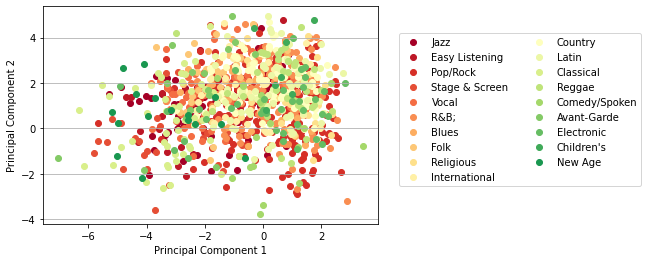

In [6]:
vect1 = np.array([ 0.24006461,  0.51178766,  0.31524798,  0.18438805,  0.48660936, -0.01623115,
                  -0.45638209, -0.26077016,  0.06859866,  0.10301124,  0.13256424, -0.02887823,])
vect2 = np.array([ 0.54121104,  -0.1981502,  0.47659031, -0.15101233,  -0.1080518,   0.1121257,
                   0.19148305, -0.17355167, -0.33586548, -0.15334972, -0.20160952, -0.38714675,])

Group = []
idx_arr=[]
x_arr=[]
y_arr=[]
genre_num = 19
fig = plt.figure()
ax = fig.add_subplot(111)
colormap = plt.cm.RdYlGn #nipy_spectral, Set1,Paired  
for idx in range(genre_num):
    data = read_genre(idx)
    sample_num = int(np.sqrt(len(data)))
    genre_data_shuffled = shuffle(data)
    data = genre_data_shuffled.values
    
    sample = []
    for i in [3,4,5,6,7,9, 10,11,12,13,14,15]:
        column = diction[i]
        mean, var = full_music_data[column]
        temp = (data[:,i] - mean) / var
        sample.append(temp)
    
    data = np.vstack(sample).T.astype(np.double)
    sample_input = data[:sample_num]
#     print(sample_input.shape)
    
    x_axis = np.sum(sample_input * vect1, axis = -1).tolist()
    y_axis = np.sum(sample_input * vect2, axis = -1).tolist()
    x_arr.extend(x_axis)
    y_arr.extend(y_axis)
    idx_arr.extend([idx]*sample_num)
    plt.scatter(x = x_axis, y = y_axis, marker='o', label = f"{dictionary[idx]}")#, c=(idx/20,idx/20,idx/20))#cmap='coolwarm' )
#     print(color)
# plt.scatter(x = x_arr, y = y_arr, marker='o',c=idx_arr, cmap='coolwarm' )
colorst = [colormap(i) for i in np.linspace(0, 0.9,len(ax.collections))]       
for t,j1 in enumerate(ax.collections):
    j1.set_color(colorst[t])
plt.legend(bbox_to_anchor=(1.05,0.9),ncol=2)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(axis="y")
plt.show()
# print(x_arr)



# 神经网络图

In [7]:
input_dim = 12
latent_size = 2
output_dim = 19

In [8]:
Net_encoder = torch.nn.Sequential(
    torch.nn.Linear(input_dim, input_dim, bias=False, ),
    torch.nn.BatchNorm1d(input_dim),
    torch.nn.LeakyReLU(),
    
    torch.nn.Linear(input_dim, input_dim, bias=False),
    torch.nn.BatchNorm1d(input_dim),
    torch.nn.LeakyReLU(),
    
    torch.nn.Linear(input_dim, latent_size, bias=False),
    torch.nn.BatchNorm1d(latent_size),
    torch.nn.Sigmoid(),
)

classifier = torch.nn.Sequential(
    torch.nn.Linear(latent_size, output_dim, bias=False, ),
    torch.nn.BatchNorm1d(output_dim),
    torch.nn.Sigmoid(),
    
    torch.nn.Linear(output_dim, output_dim, bias=False, ),
    torch.nn.BatchNorm1d(output_dim),
    torch.nn.LeakyReLU(),
    
    torch.nn.Linear(output_dim, output_dim, bias=False, ),
    torch.nn.BatchNorm1d(output_dim),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(output_dim, output_dim, bias=False, ),
    torch.nn.BatchNorm1d(output_dim),
    torch.nn.LeakyReLU(),
)

In [9]:
check_point_encoder = "check_point/Net_encoder_para2.pkl"
check_point_decoder = "check_point/Net_decoder_para2.pkl"
Net_encoder.load_state_dict(torch.load(check_point_encoder))
classifier.load_state_dict(torch.load(check_point_decoder))
classifier = classifier.double()

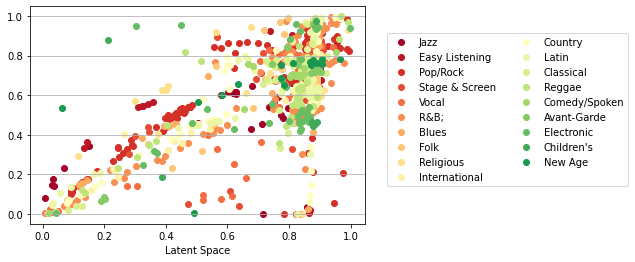

In [10]:
Group = []
genre_num = 19
Net_encoder.float()
fig = plt.figure()
ax = fig.add_subplot(111)

for idx in range(genre_num):
    data = read_genre(idx)
    sample_num = int(np.sqrt(len(data)))
    genre_data_shuffled = shuffle(data)
    data = genre_data_shuffled.values
    
    sample = []
    for i in [3,4,5,6,7,9, 10,11,12,13,14,15]:
        column = diction[i]
        mean, var = full_music_data[column]
        temp = (data[:,i] - mean) / var
        sample.append(temp)
    
    data = np.vstack(sample).T.astype(np.double)
    sample_input = torch.tensor(data[:sample_num],requires_grad = False,dtype = torch.float)
    
    dots  = Net_encoder(sample_input).detach().numpy().T
    plt.scatter(x = dots[0], y = dots[1], label = f"{dictionary[idx]}")
    
colorst = [colormap(i) for i in np.linspace(0, 0.9,len(ax.collections))]       
for t,j1 in enumerate(ax.collections):
    j1.set_color(colorst[t])
    
plt.legend(bbox_to_anchor=(1.05,0.9),ncol=2)
plt.xlabel("Latent Space")
# plt.ylabel("Principal Component 2")
plt.grid(axis="y")


plt.show()

In [ ]:

                 ["danceability", "energy",     "valence",    "tempo",   "loudness",    "mode",    "acousticness", "instrumentalness","liveness",  "speechiness","explicit",   "duration_ms"]
vect1 = np.array([ 0.24006461,    0.51178766,  0.31524798,  0.18438805,  0.48660936,  -0.01623115,  -0.45638209,      -0.26077016,    0.06859866,  0.10301124,   0.13256424,  -0.02887823,])
vect2 = np.array([ 0.54121104,  -0.1981502,  0.47659031,   -0.15101233,  -0.1080518,   0.1121257,    0.19148305,       -0.17355167,    -0.33586548,  -0.15334972,  -0.20160952, -0.38714675,])